# Function to extract evaluation metrics

In [2]:
import os
import openai

openai.api_key = os.environ.get("OPENAI_API_KEY")

def extract_metric_from_text(text):
    prompt = f"""
Extract the evaluation metric described in the following competition/task documentation.

Return only the name or description of the evaluation metric — exactly as referred to in the text.
This may be a standard metric like "accuracy", or a custom/user-defined metric like "mean average precision at 5" or "quadratic weighted kappa".

Text:
\"\"\"{text}\"\"\"

Evaluation Metric:
"""

    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",  # or "gpt-3.5-turbo"
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=100,
    )

    return response.choices[0].message["content"].strip()

# Example
text = """### Evaluation

link

keyboard_arrow_up

## Goal

It is your job to predict if a passenger survived the sinking of the Titanic
or not.  
For each in the test set, you must predict a 0 or 1 value for the variable.

## Metric

Your score is the percentage of passengers you correctly predict. This is
known as
[accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification).
"""

metric = extract_metric_from_text(text)
print("Evaluation Metric:", metric)


Evaluation Metric: accuracy


In [ ]:
def generate_competition_category(tags):

    prompt = f"""
Given the following tags for a machine learning competition, generate a very concise category label.

The label should:
- Use a **single word** for the ML task (e.g., "classification", "regression", "segmentation", "forecasting", etc.)
- Include the **data type** in parentheses (e.g., "(tabular)", "(text)", "(image)", "(time series)")

Avoid any extra words or punctuation beyond that. Return only the category label in this exact format:
task (data_type)

Tags:
{tags}

Category:
"""

    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=20,
    )

    return response.choices[0].message["content"].strip()


In [7]:
tags = [
    "Binary Classification",
    "Tabular",
    "Beginner",
    "Categorization Accuracy"
]

print(generate_competition_category(tags))


classification (tabular)


In [17]:
def format_kaggle_dataset_summary(description_text):
    prompt = f"""
You are given a long description of a Kaggle competition. Your task is to extract and format key information in the following structure:

## Dataset Overview

Each dataset includes the following files:

- **train.csv**: [summary of what this contains]
- **test.csv**: [summary of what this contains]
- **sample_submission.csv** (or similar): [summary if provided]

## Submission Format

Participants are expected to generate a submission file that mirrors the structure of the sample submission.

- Required columns
- Number of rows
- Format requirements (e.g., CSV with specific columns)

## Dataset-Specific Information

### Target Variable

- **[Variable Name]**: [What it represents and its possible values]

### Features

List each important feature with its definition and possible values if mentioned.

Now format the following description into the above structure:

\"\"\"{description_text}\"\"\"
"""

    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=1000,
    )

    return response.choices[0].message["content"].strip()


# Read the json files and generate record to insert into MongoDB

In [ ]:
import os
import json
from datetime import datetime
from bson import ObjectId
from pymongo import MongoClient
import csv

# === Config ===
JSON_FILE = "/Users/zhongming/Local Docs/Github/Kaggle_RAG_dataset/data/test/competitions.json"
DATA_FOLDER = "/Users/zhongming/Local Docs/Github/Kaggle_RAG_dataset/data/test/dataset/titanic"
#MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "agentds"
DOMAINS_COLLECTION = "domains"
DATASETS_COLLECTION = "kaggle_datasets"

# === Load competition JSON ===
with open(JSON_FILE, 'r') as f:
    raw_data = json.load(f)

titanic = raw_data.get("titanic", {})

# === Helper Functions ===

def infer_file_type(filename):
    filename = filename.lower()
    if "train" in filename:
        return "train"
    elif "test" in filename:
        return "test"
    elif "sample" in filename or "submission" in filename:
        return "sample_submission"
    else:
        return "unknown"

def scan_dataset_folder(base_folder):
    dataset_files = []
    for root, _, files in os.walk(base_folder):
        for filename in files:
            if filename.endswith(".csv"):
                filepath = os.path.join(root, filename)
                rel_path = os.path.relpath(filepath, base_folder)
                with open(filepath, "r") as f:
                    content = f.read()
                dataset_files.append({
                    "name": filename,
                    "path": rel_path,
                    "type": infer_file_type(filename),
                    "content": content
                })
    return dataset_files

def count_csv_rows_from_files(files):
    for f in files:
        if f["type"] == "test":
            return sum(1 for _ in csv.reader(f["content"].splitlines())) - 1  # minus header
    return 0

# === Insert dataset first ===
def insert_dataset(domain_name, files):
    dataset_doc = {
        "_id": ObjectId(),
        "domain_name": domain_name,
        "files": files,
        "created_at": datetime.now(),
        "source": "Kaggle"
    }
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[DATASETS_COLLECTION]
    collection.insert_one(dataset_doc)
    print("✅ Dataset inserted.")
    return dataset_doc["_id"], files

# === Insert domain ===
def insert_domain(domain_doc):
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[DOMAINS_COLLECTION]
    collection.insert_one(domain_doc)
    print("✅ Domain inserted.")

# === Start Processing ===
files = scan_dataset_folder(DATA_FOLDER)


In [ ]:
dataset_id, scanned_files = insert_dataset("titanic", files)

# === Build domain doc ===
mapped_doc = {
    "_id": ObjectId(),
    "category": generate_competition_category(titanic.get("Tags", "")),
    "created_at": datetime.now(),
    "data_source": "Kaggle",
    "description": format_kaggle_dataset_summary(f"{titanic.get('Description', '').strip()}\n\n{titanic.get('data', {}).get('Description', '').strip()}"),
    "evaluation_metric": extract_metric_from_text(titanic.get("Evaluation", "")),
    "is_active": True,
    "name": "titanic",
    "sample_submission": ObjectId('68071ca2ad4b67c7a3e90521'),
    "test": ObjectId('68071ca2ad4b67c7a3e90521'),
    "test_size": 418,#count_csv_rows_from_files(scanned_files),
    "test_target": "Kaggle",  # manually set or extracted
    "total_num_tasks": 5,       # optional, depends on task
    "train": ObjectId('68071ca2ad4b67c7a3e90521'),
}

insert_domain(mapped_doc)


# load notebooks into collections

1. utlize the mongodb class we built
2. modify the score caluclation logic to ensure score scale from 0-1
3. import the notebooks, change the code to ensure _id is object ID
4. when importing, link to the object id from domains (so we need to query the domain using domain_name e.g., titanic from the metadata file)
5. done

In [5]:
import sys
import os
import json

# Add the parent directory of this notebook to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Now you can import from src/data_management
from data_management.data_manager import DataManager

from datetime import datetime, timedelta
import re
def parse_custom_date(date_str):
    """
    Converts a date string like "Thu Jun 23 2022 17:25:16 GMT-0700 (Mountain Standard Time)"
    into a Python datetime object.
    """
    # Extract the main date part (before the timezone parentheses)
    date_part = date_str.split(' (')[0]
    
    # Parse the timezone offset (e.g., "-0700")
    tz_offset_str = re.search(r"GMT([+-]\d{4})", date_part).group(1)
    tz_offset = int(tz_offset_str) // 100  # Convert "-0700" to -7 hours
    
    # Remove the timezone part for easier parsing
    clean_date_str = re.sub(r" GMT[+-]\d{4}", "", date_part)
    
    # Parse the cleaned date string
    dt = datetime.strptime(clean_date_str, "%a %b %d %Y %H:%M:%S")
    
    # Adjust for timezone offset (optional, if you want UTC)
    dt_utc = dt - timedelta(hours=tz_offset)  # Fixed: Use timedelta directly
    
    return dt_utc  # or return dt (if keeping original offset)


In [6]:
def import_notebooks_from_directory(base_dir: str):
    """
    Import notebooks from competition directories using the new class structure
    
    Args:
        base_dir: Base directory containing competition folders with notebook files
    """
    # Initialize data manager
    with DataManager(MONGO_URI,DB_NAME) as dm:
        # Get all competition directories
        competition_dirs = [d for d in os.listdir(base_dir) 
                          if os.path.isdir(os.path.join(base_dir, d))]
        competition_dirs = ['titanic']
        total_notebooks = 0
        total_imported = 0

        # Process each competition directory
        for competition_id in competition_dirs:
            notebook_folder_path = os.path.join(base_dir, competition_id)
            
            # Check if competition exists using CompetitionManager
            if not dm.competitions.exists(competition_id):
                print(f"Competition {competition_id} does not exist in the database, skipping...")
                continue
            
            # Define paths for notebooks and metadata
            notebooks_dir = notebook_folder_path
            metadata_dir = os.path.join(notebook_folder_path, "metadata")
            metadata_file = os.path.join(metadata_dir, "all_notebooks_metadata.json")
            
            # Check if required directories exist
            if not os.path.exists(notebooks_dir):
                print(f"No notebooks directory found for competition {competition_id}")
                continue
                
            if not os.path.exists(metadata_file):
                print(f"No metadata file found for competition {competition_id}")
                continue
            
            print(f"\nProcessing competition: {competition_id}")
            
            # Load metadata
            try:
                with open(metadata_file, 'r') as f:
                    metadata_dict = json.load(f)
            except Exception as e:
                print(f"Error loading metadata for {competition_id}: {str(e)}")
                continue
            
            success_count = 0
            processed_count = 0
            
            # Process each notebook in metadata
            for url, metadata in metadata_dict.items():
                notebook_name = metadata.get('notebook_name')
                if not notebook_name:
                    print(f"Skipping entry with missing notebook_name: {url}")
                    continue

                # Construct notebook file path
                notebook_file = os.path.join(notebooks_dir, f"{notebook_name}.ipynb")
                
                if not os.path.isfile(notebook_file):
                    print(f"Notebook file not found: {notebook_file}")
                    continue
                
                # Add URL back to metadata
                metadata['url'] = url
                # convert the date_created to datetime
                if 'date_created' in metadata:
                    metadata['date_created'] = parse_custom_date(metadata['date_created'])
                # drop notebook_name from metadata
                metadata.pop('notebook_name', None)
                
                
                # Import notebook using NotebookManager
                try:
                    if dm.notebooks.import_from_file(notebook_file, competition_id, metadata):
                        success_count += 1
                        print(f"✓ Imported notebook: {notebook_name}")
                    else:
                        print(f"✗ Failed to import notebook: {notebook_name}")
                except Exception as e:
                    print(f"Error importing notebook {notebook_name}: {str(e)}")
                
                processed_count += 1
            
            print(f"Imported {success_count} of {processed_count} notebooks for {competition_id}")
            
            total_notebooks += processed_count
            total_imported += success_count
            updates_scores_count = dm.notebooks.recalculate_scores(competition_id,True)
            print(f"Total updates scores made for {competition_id}: {updates_scores_count}")

        # Print final summary
        print(f"\nFinal Summary:")
        print(f"Total notebooks processed: {total_notebooks}")
        print(f"Total notebooks imported: {total_imported}")
        print(f"Success rate: {(total_imported/total_notebooks)*100:.2f}%" if total_notebooks > 0 else "No notebooks processed")
# Example usage
if __name__ == "__main__":
    notebooks_base_dir = '/Users/zhongming/Local Docs/Github/Kaggle_RAG_dataset/data/test/notebooks'
    import_notebooks_from_directory(notebooks_base_dir)


Processing competition: titanic
✓ Imported notebook: alexisbcook_titanic-tutorial
✓ Imported notebook: gusthema_titanic-competition-w-tensorflow-decision-forests
✓ Imported notebook: startupsci_titanic-data-science-solutions
✓ Imported notebook: ldfreeman3_a-data-science-framework-to-achieve-99-accuracy
✓ Imported notebook: arthurtok_introduction-to-ensembling-stacking-in-python
Notebook file not found: /Users/zhongming/Local Docs/Github/Kaggle_RAG_dataset/data/test/notebooks/titanic/mrisdal_exploring-survival-on-the-titanic.ipynb
✓ Imported notebook: ash316_eda-to-prediction-dietanic
✓ Imported notebook: yassineghouzam_titanic-top-4-with-ensemble-modeling
✓ Imported notebook: gunesevitan_titanic-advanced-feature-engineering-tutorial
✓ Imported notebook: nadintamer_titanic-survival-predictions-beginner
✓ Imported notebook: masumrumi_a-statistical-analysis-ml-workflow-of-titanic
✓ Imported notebook: jhoward_linear-model-and-neural-net-from-scratch
✓ Imported notebook: omarelgabry_a-jou

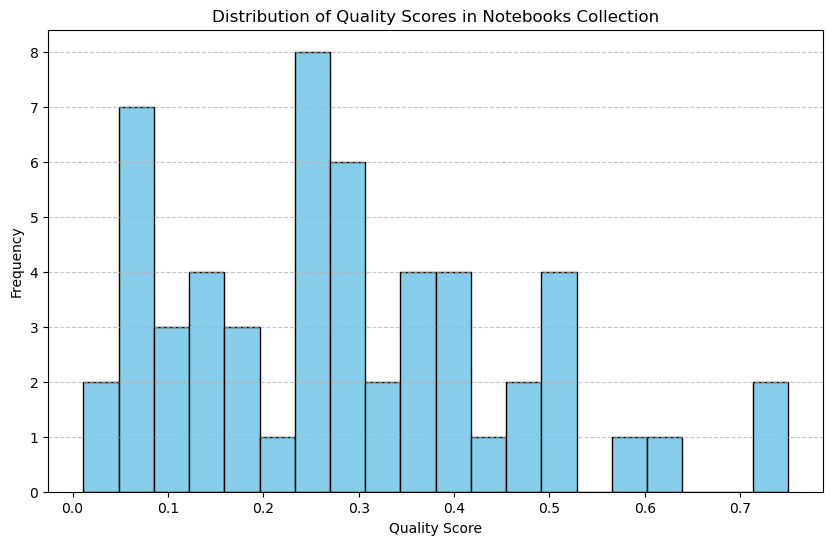

In [3]:
from pymongo import MongoClient

import matplotlib.pyplot as plt
MONGO_URI = "mongodb://localhost:27017"
# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client["kaggle_platform"]
notebooks_collection = db["notebooks"]

# Query the notebooks collection to retrieve the scores['quality'] attribute
quality_scores = []
for notebook in notebooks_collection.find({}, {"scores.quality": 1}):
    quality = notebook.get("scores", {}).get("quality")
    if quality is not None:
        quality_scores.append(quality)

# Plot the distribution of quality scores
plt.figure(figsize=(10, 6))
plt.hist(quality_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Quality Scores in Notebooks Collection")
plt.xlabel("Quality Score")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# load tasks into collections

1. after importing notebooks, conduct initial data analysis
2. finalze notebooks on each round
3. finalize the logic on notebook selections
4. generate each round notebook selectd records and iserted
5. done for titanic

In [ ]:
from pymongo import MongoClient
from bson import ObjectId
from datetime import datetime
import random
import numpy as np

# MongoDB configuration
DB_NAME = "agentds"
TASKS_COLLECTION = "tasks"

def get_domain_id_by_name(db, domain_name):
    """Retrieve domain ObjectId by name from domains collection"""
    domain = db[DOMAINS_COLLECTION].find_one({"name": domain_name})
    if not domain:
        raise ValueError(f"Domain '{domain_name}' not found in domains collection")
    return domain["_id"]

def generate_and_insert_tasks(domain_name, num_of_tasks, task_instruction):
    """
    Generate and insert task records with progressively higher quality notebooks each round.
    Starts with lowest quality notebooks in Round 1 and progresses to highest quality in final round.
    """
    try:
        # Connect to MongoDB
        client = MongoClient(MONGO_URI)
        db = client[DB_NAME]
        
        # Get domain ID
        domain_id = get_domain_id_by_name(db, domain_name)
        
        # Query all notebooks for the domain with their quality scores
        all_notebooks = list(
            db.notebooks.find(
                {"domain_name": domain_name, "scores.quality": {"$exists": True}},
                {"_id": 1, "scores.quality": 1}
            ).sort("scores.quality", 1)  # Sort by quality ascending (low to high)
        )
        
        if not all_notebooks:
            raise ValueError(f"No notebooks found for domain '{domain_name}' with quality scores")
        
        # Calculate the number of notebooks per task
        notebooks_per_task = len(all_notebooks) // num_of_tasks
        if notebooks_per_task < 5:
            print(f"⚠️ Warning: Only {notebooks_per_task} notebooks available per task (recommend at least 5)")
        
        tasks = []
        for task_number in range(1, num_of_tasks + 1):
            # Calculate the slice of notebooks for this task
            start_idx = (task_number - 1) * notebooks_per_task
            end_idx = task_number * notebooks_per_task
            
            # For the last task, include any remaining notebooks
            if task_number == num_of_tasks:
                end_idx = len(all_notebooks)
            
            task_notebooks = all_notebooks[start_idx:end_idx]
            
            # Randomly sample up to 5 notebooks from this quality range
            sample_size = min(5, len(task_notebooks))
            selected_notebooks = random.sample(task_notebooks, sample_size) if task_notebooks else []
            
            notebook_ids = [notebook["_id"] for notebook in selected_notebooks]
            
            # Calculate quality range stats
            if task_notebooks:
                qualities = [n["scores"]["quality"] for n in task_notebooks]
                min_quality = min(qualities)
                max_quality = max(qualities)
                avg_quality = sum(qualities) / len(qualities)
            else:
                min_quality = max_quality = avg_quality = 0
            
            task = {
                "_id": ObjectId(),
                "domain_id": domain_id,
                "num_of_tasks": num_of_tasks,
                "type_of_tasks": "Submit a prediction result based on the reference notebook.",
                "task_instruction": task_instruction,
                "task_number": task_number,
                "side_information_list": notebook_ids,
                "created_at": datetime.utcnow(),
                "is_active": True,
                "domain_name": domain_name,
                "quality_stats": {
                    "min": float(min_quality),
                    "max": float(max_quality),
                    "avg": float(avg_quality),
                    "notebooks_count": len(task_notebooks)
                }
            }
            tasks.append(task)
        
        # Insert tasks into the tasks collection
        if tasks:
            db[TASKS_COLLECTION].insert_many(tasks)
            print(f"✅ {len(tasks)} tasks inserted into the tasks collection for domain '{domain_name}'")
            print("\nTask quality progression:")
            for task in sorted(tasks, key=lambda x: x["task_number"]):
                stats = task["quality_stats"]
                print(f"Round {task['task_number']}: {stats['min']:.2f}-{stats['max']:.2f} (avg: {stats['avg']:.2f}) - {stats['notebooks_count']} notebooks")
        else:
            print("⚠️ No tasks were generated")
            
    except Exception as e:
        print(f"❌ Error: {str(e)}")
    finally:
        client.close()

if __name__ == "__main__":
    # Example usage
    domain_name = "titanic"  # Replace with your domain name
    num_tasks = 5           # Number of rounds/tasks to generate
    task_instruction = "Predict the survival rate based on the given features"
    
    generate_and_insert_tasks(
        domain_name=domain_name,
        num_of_tasks=num_tasks,
        task_instruction=task_instruction
    )

✅ 5 tasks inserted into the tasks collection for domain 'titanic'

Task quality progression:
Round 1: 0.01-0.10 (avg: 0.06) - 11 notebooks
Round 2: 0.11-0.24 (avg: 0.17) - 11 notebooks
Round 3: 0.25-0.30 (avg: 0.27) - 11 notebooks
Round 4: 0.30-0.40 (avg: 0.36) - 11 notebooks
Round 5: 0.44-0.75 (avg: 0.56) - 11 notebooks
